## Feed forward

In the following cell, we will define functions to set up our neural network.
Namely an activation function, $\sigma(z)$, it's derivative, $\sigma'(z)$, a function to initialise weights and biases, and a function that calculates each activation of the network using feed-forward.

Recall the feed-forward equations,
$$ \mathbf{a}^{(n)} = \sigma(\mathbf{z}^{(n)}) $$
$$ \mathbf{z}^{(n)} = \mathbf{W}^{(n)}\mathbf{a}^{(n-1)} + \mathbf{b}^{(n)} $$

In this worksheet we will use the *logistic function* as our activation function, rather than the more familiar $\tanh$.
$$ \sigma(\mathbf{z}) = \frac{1}{1 + \exp(-\mathbf{z})} $$
**Run the following cells before continuing.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import pandas as pd
your_module = drive.CreateFile({'id':'1DbqD6MfKXnAQRqvRsUkUObu6LWxEISRD'})
your_module.GetContentFile('test_img.png')
minh_hoa = drive.CreateFile({'id':'1d3c278G3JKiBrOzo82FpHoUhUPtLAfiR'})
minh_hoa.GetContentFile('minh_hoa.png')
test_1 = drive.CreateFile({'id':'1ETYPUyU75XBYUiQpCbDQUKHor2lz2KGj'})
test_1.GetContentFile('test1_img.png')
test_2 = drive.CreateFile({'id':'123IA41GK5S2NmmtYEetJDDpzXRUWzxWD'})
test_2.GetContentFile('test2_img.png')

## Define activation function $\sigma(z)$  and it's derivative $\sigma'(z)$

In [ ]:
simga = lambda x:(1 / (1 + np.exp( -x )))
dsigma = lambda x:simga(x) * (1 - simga(x))
vidu = np.array([[1],[2],[3]])
vidu

array([[1],
       [2],
       [3]])

## Setup weight and bias
![markdown]('minh_hoa.png')

In [ ]:
def setup_b(a):
    b = []
    for i in range(len(a) - 1):
        b.append(random.random((a[i + 1],1)) / a[i + 1])
    return b
def setup_weight(a):
    b = []
    for i in range(len(a) - 1):
        b.append(random.random((a[i + 1],a[i])) / a[i])
    return b
w = setup_weight([784,32,32,10])
for i in range(len(w)):
    print('shape of the weight ',i,'=',np.shape(w[i]))
print('----------------------------------------------')
b = setup_b([784,32,32,10])
for i in range(len(w)):
    print('shape of the bias ',i,'=',np.shape(b[i]))

shape of the weight  0 = (32, 784)
shape of the weight  1 = (32, 32)
shape of the weight  2 = (10, 32)
----------------------------------------------
shape of the bias  0 = (32, 1)
shape of the bias  1 = (32, 1)
shape of the bias  2 = (10, 1)


## Illustration of data train
The MNIST database is a large database of handwritten digits commonly used in training various image processing systems. This database is also widely used for training and testing in the field of machine learning. The database was created by "remixing" samples from the original NIST data set. The creators of the database felt that because the NIST training data set was taken from the US Census Bureau, while the testing data set was taken from US high school students, So it is not suitable for machine learning experiments. Furthermore, the black-and-white images from NIST were normalized to fit a 28x28 pixel bounding box and spatial anti-aliasing with the introduction of grayscale levels.

In [ ]:
from keras.datasets import mnist
(train_features, train_targets), (test_features, test_targets) = mnist.load_data()
def data():
        result = []
        for img,y in zip(train_features, train_targets):
            y1 = np.zeros((10, 1))
            y1[y] = 1
            b = img.reshape(-1,1) / 255
            result.append((y1,b))
        return result
train_feature = data()
print('Shape of train features ',np.shape(train_feature[0][1]))
print('Shape of train label ',np.shape(train_feature[0][0]))


11490434/11490434 [==============================] - 0s 0us/step
Shape of train features  (784, 1)
Shape of train label  (10, 1)


## Illustration of training data

sample train label
  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


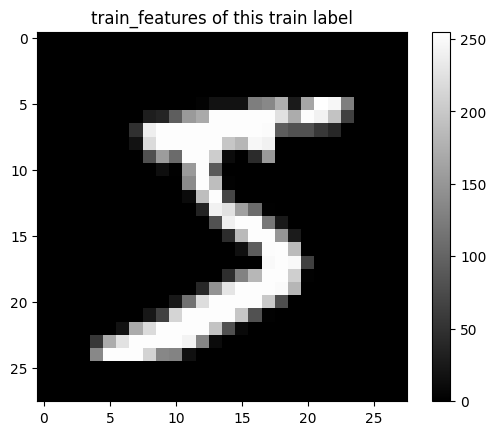

In [ ]:
print('sample train label\n ',train_feature[0][0])
data_array = np.array(train_feature[0][1]).reshape((28, 28))*255
plt.imshow(data_array, cmap='gray')
plt.colorbar()
plt.title('train_features of this train label')
plt.show()

## Calculate the layer of neural network
Recall the feed-forward equations,
 $$ \mathbf{a}^{(n)} = \sigma(\mathbf{z}^{(n)}) $$
$$ \mathbf{z}^{(n)} = \mathbf{W}^{(n)}\mathbf{a}^{(n-1)} + \mathbf{b}^{(n)} $$


In [ ]:
def computing(a, w, b):
    c = [a]
    for index, i in enumerate(w):
        k = b[index]
        sd = i @ a
        a = simga(sd + k)
        c.append(a)
    return c
def z(a,w,b):
    c = []
    for index, i in enumerate(w):
        c.append(i @ a + b[index])
        a = simga(i @ a + b[index])
    return c

## Backpropagation

In the next cells, you will be asked to complete functions for the Jacobian of the cost function with respect to the weights and biases.
We will start with layer 3, which is the easiest, and work backwards through the layers.

We'll define our Jacobians as,
$$ \mathbf{J}_{\mathbf{W}^{(3)}} = \frac{\partial C}{\partial \mathbf{W}^{(3)}} $$
$$ \mathbf{J}_{\mathbf{b}^{(3)}} = \frac{\partial C}{\partial \mathbf{b}^{(3)}} $$
etc., where $C$ is the average cost function over the training set. i.e.,
$$ C = \frac{1}{N}\sum_k C_k $$
You calculated the following in the practice quizzes,
$$ \frac{\partial C}{\partial \mathbf{W}^{(3)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{W}^{(3)}}
   ,$$
for the weight, and similarly for the bias,
$$ \frac{\partial C}{\partial \mathbf{b}^{(3)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{b}^{(3)}}
   .$$
With the partial derivatives taking the form,
$$ \frac{\partial C}{\partial \mathbf{a}^{(3)}} = 2(\mathbf{a}^{(3)} - \mathbf{y}) $$
$$ \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}} = \sigma'({z}^{(3)})$$    
$$ \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{W}^{(3)}} = \mathbf{a}^{(2)}$$
$$ \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{b}^{(3)}} = 1$$

We'll do the J_W3 ($\mathbf{J}_{\mathbf{W}^{(3)}}$) function for you, so you can see how it works.
You should then be able to adapt the J_b3 function, with help, yourself.

In [ ]:
def jacobian_w(a0,y):
    a = computing(a0, w, b)
    j_w=[]
    z1 = z(a0, w, b)
    j_a = 2 * (a[-1] - y)
    for i in range(1, len(w) + 1):
        dz=j_a * dsigma(z1[len(b) - i])
        dw = dz @ a[len(a) - i - 1].T
        j_w.append(dw)
        k = w[len(w) - i]
        j_a = (dz.T @ k).T
    return j_w
def jacobian_b(a0,y):
    a=computing(a0, w, b)
    j_b=[]
    z1=z(a0, w, b)
    j_a=2 * (a[ -1 ] - y)
    for i in range(1,len(b) + 1):
        dz=j_a*dsigma(z1[len(b) - i])
        j_b.append(dz)
        k=w[len(w) - i]
        j_a=(dz.T @ k).T
    return j_b


# Gradient Descent in Neural Networks

1.   Mục danh sách
2.   Mục danh sách


## 1. Introduction

Neural networks are trained to approximate complex functions by adjusting their weights and biases. The goal is to minimize a loss function, which measures the difference between the network's predictions and the actual target values. Gradient descent is the algorithm used to find the optimal weights and biases that minimize this loss function.

## 2. Loss Function

A loss function, also known as a cost function or objective function, quantifies the error between the predicted outputs and the actual outputs. Common loss functions include Mean Squared Error (MSE) for regression tasks and Cross-Entropy Loss for classification tasks.
<br>
In this project, we use the mean squared error $ MSE = \frac{1}{N}\sum_{i=1}^{n}(\hat{y_{i}} - y_{i})^2 $
## 3. Gradient Descent Algorithm

Gradient Descent updates the weights of the network in the opposite direction of the gradient of the loss function with respect to the weights. This process is repeated iteratively until the algorithm converges to a minimum of the loss function.

### 3.1. Basic Gradient Descent

The basic gradient descent algorithm can be described as follows:

1. Initialize the weights $ W $ and biases $ b $ with random values.
2. Compute the gradient of the loss function $ L $ with respect to each weight $ W_i $ and bias $ b_i $:
   $
   \frac{\partial \mathcal{L}}{\partial W_i}, \quad \frac{\partial \mathcal{L}}{\partial b_i}
   $
3. Update the weights and biases using the learning rate $\alpha$:
   $
   W_i \leftarrow W_i - \alpha \frac{\partial \mathcal{L}}{\partial W_i}, \quad b_i \leftarrow b_i - \alpha \frac{\partial \mathcal{L}}{\partial b_i}
   $
4. Repeat steps 2-3 until convergence.


In [ ]:
def gradient_descent(a0,y,w,b):
    jw=jacobian_w(a0,y)
    jb=jacobian_b(a0,y)
    for i in range(len(b)):
        b[i]=b[i] - 0.05 * jb[len(b)-i-1]
    for i in range(len(w)):
        w[i] = w[i] - 0.05 * jw[len(b) - i - 1]
    return w,b
def cost_function(a0,y,w,b):
    y_hat = computing(a0, w, b)[-1]
    cost = np.sum(((y_hat - y) ** 2))
    return cost

In [ ]:
print(cost_function(train_feature[0][1],train_feature[0][0],w,b))

3.181657166711293


## Calculator Accuracy

In [ ]:
def te():
        pas = 0
        for index,i in enumerate(test_features):
            a = computing(i.reshape(-1,1)/255,w,b)[-1]
            ke = [0,1,2,3,4,5,6,7,8,9]
            ke.sort(key=lambda x: a[x],reverse=True)
            if ke[0] == test_targets[index]:
                pas+=1
        return pas / len(test_features)

In [ ]:
def average_cost():
    average = 0
    for index,i in enumerate(train_feature):
        average += cost_function(i[1],i[0],w,b)
    return average / len(train_features)

## Training model

In [ ]:
average = average_cost()
count = 0
epochs = 5
while count < epochs:
    random.shuffle(train_features)
    for index,i in enumerate(train_feature):
        w,b = gradient_descent(i[1], i[0],w,b)
    # calculator the average of cost function
    average_costs = average_cost()
    print('Pack', count)
    print('Average cost of training is ',average_costs)
    print('Accuracy of model is ',te())
    average = average_costs
    count +=1

Pack 0
Average cost of training is  0.8990531674922411
Accuracy of model is  0.0958
Pack 1
Average cost of training is  0.32254831349553564
Accuracy of model is  0.8357
Pack 2
Average cost of training is  0.12175155344745198
Accuracy of model is  0.9221
Pack 3
Average cost of training is  0.0933689153332047
Accuracy of model is  0.9356
Pack 4
Average cost of training is  0.08104023977734498
Accuracy of model is  0.9437


## Confusion Matrix

In [ ]:
conf_mat = np.array([[0]*10]*10)
for index,i in enumerate(test_features):
    a = computing(i.reshape(-1,1)/255,w,b)[-1]
    ke = [0,1,2,3,4,5,6,7,8,9]
    ke.sort(key=lambda x: a[x],reverse=True)
    conf_mat[int(ke[0])][test_targets[index]] +=1
print(conf_mat)


[[ 959    0   14    4    1    9   14    3    7    5]
 [   0 1120    3    0    1    1    3   20    4    5]
 [   0    2  948    6    5    0    1   17    1    0]
 [   1    3   20  952    0   17    0   10   18    5]
 [   4    1   10    0  923    8    9    5    9   11]
 [   7    2    1   24    0  826   12    2   10    6]
 [   3    1   10    1    6    7  907    0    8    1]
 [   2    2    6    9    1    1    0  943    4    9]
 [   4    4   17   10    4   17   11    3  906   14]
 [   0    0    3    4   41    6    1   25    7  953]]


Text(0.5, 47.7222222222222, 'Predicted Labels')

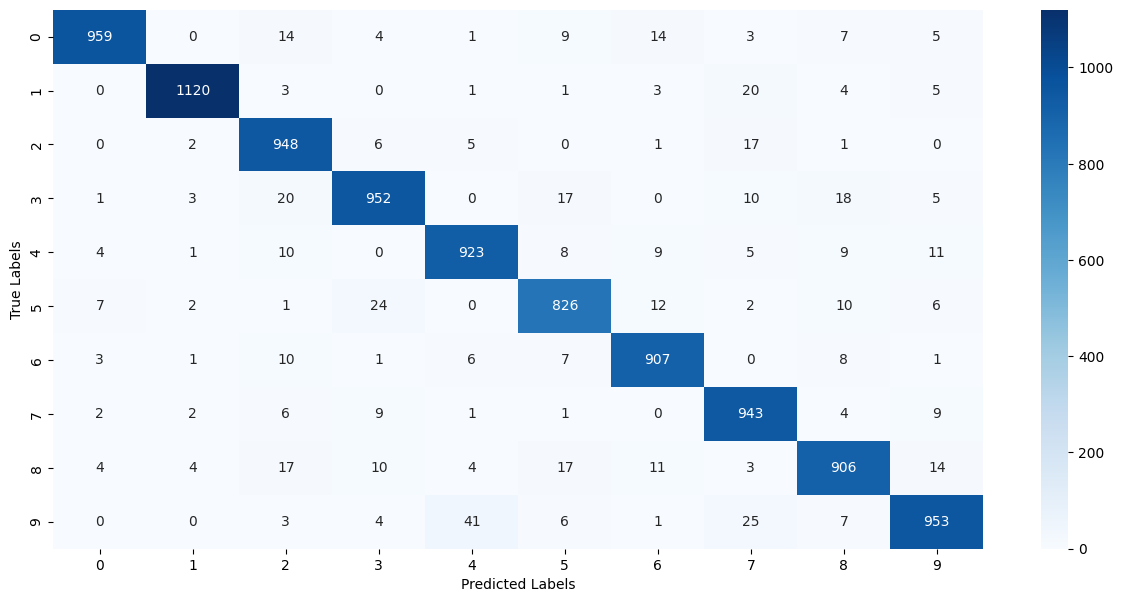

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

## Building a Predictive System

In [ ]:
input_image_path = 'test_img.png'

input_image = cv2.imread(input_image_path,0)

In [ ]:
type(input_image)

numpy.ndarray

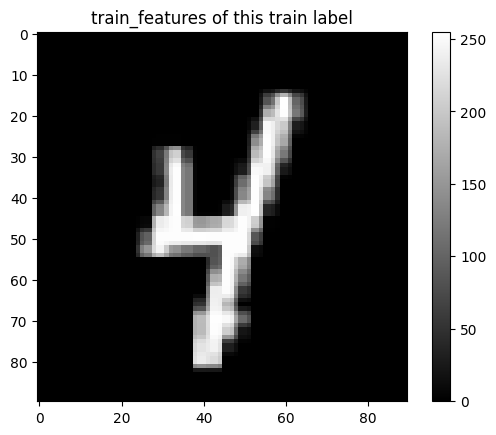

In [ ]:
plt.imshow(input_image, cmap='gray')
plt.colorbar()
plt.title('train_features of this train label')
plt.show()

In [ ]:
input_image_resize = cv2.resize(input_image, (28, 28))
image_reshaped = np.reshape(input_image_resize, [1,28,28])
label = image_reshaped.reshape((-1,1))/255
output = computing(label,w,b)[-1]
print(output)

[[3.95094651e-06]
 [6.41393641e-03]
 [1.54012020e-04]
 [1.94756180e-08]
 [9.83881755e-01]
 [1.27703199e-02]
 [7.12306763e-03]
 [5.53394360e-05]
 [7.87408822e-04]
 [5.21122887e-02]]


In [ ]:
ke = [0,1,2,3,4,5,6,7,8,9]
ke.sort(key=lambda x: output[x],reverse=True)
print('The Handwritten Digit is recognised as ',ke[0])

The Handwritten Digit is recognised as  4


In [ ]:
input_image_path = 'test1_img.png'

input_image = cv2.imread(input_image_path,0)

In [ ]:
type(input_image)

numpy.ndarray

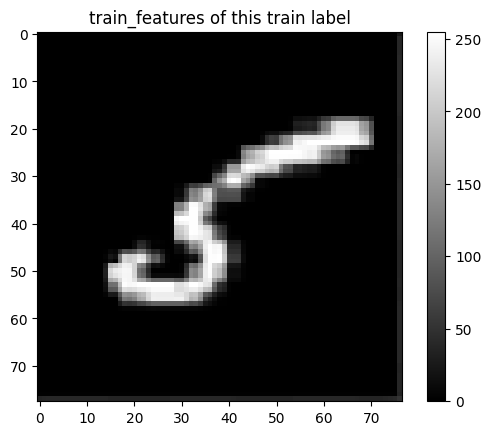

In [ ]:
plt.imshow(input_image, cmap='gray')
plt.colorbar()
plt.title('train_features of this train label')
plt.show()

In [ ]:
input_image_resize = cv2.resize(input_image, (28, 28))
image_reshaped = np.reshape(input_image_resize, [1,28,28])
label = image_reshaped.reshape((-1,1))/255
output = computing(label,w,b)[-1]
print(output)

[[3.00145925e-04]
 [5.35824448e-03]
 [5.86639346e-06]
 [1.91289057e-03]
 [1.15017979e-02]
 [9.92234734e-01]
 [3.91515985e-03]
 [8.06311529e-05]
 [1.90468917e-02]
 [6.23388168e-04]]


In [ ]:
ke = [0,1,2,3,4,5,6,7,8,9]
ke.sort(key=lambda x: output[x],reverse=True)
print('The Handwritten Digit is recognised as ',ke[0])

The Handwritten Digit is recognised as  5


In [ ]:
input_image_path = 'test2_img.png'

input_image = cv2.imread(input_image_path,0)

In [ ]:
type(input_image)

numpy.ndarray

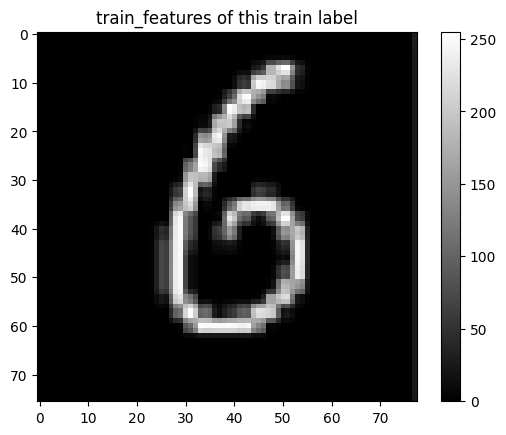

In [ ]:
plt.imshow(input_image, cmap='gray')
plt.colorbar()
plt.title('train_features of this train label')
plt.show()

In [ ]:
input_image_resize = cv2.resize(input_image, (28, 28))
image_reshaped = np.reshape(input_image_resize, [1,28,28])
label = image_reshaped.reshape((-1,1))/255
output = computing(label,w,b)[-1]
print(output)

[[4.72259307e-03]
 [5.05492113e-04]
 [9.12661142e-04]
 [3.36404864e-05]
 [2.55057045e-03]
 [4.97457947e-02]
 [9.30856123e-01]
 [6.51996083e-07]
 [8.01448518e-03]
 [6.44514490e-05]]


In [ ]:
ke = [0,1,2,3,4,5,6,7,8,9]
ke.sort(key=lambda x: output[x],reverse=True)
print('The Handwritten Digit is recognised as ',ke[0])

The Handwritten Digit is recognised as  6
